# Adding a cut in front of an NN

Here we will add two cuts in front of the same NN we used last time.

In [1]:
import jax
import jax.numpy as jnp
import numpy
import matplotlib.pyplot as plt
from samples import data_back, sig_avg, sig_width
from jax_helpers import erf, train
import haiku as hk
from typing import List, Optional

_ = plt.ion()

Load up the 2D data.
* To avoid normalization issues, we make the data sets the same size.

In [2]:
key = jax.random.PRNGKey(1234)
signal_data = jax.random.multivariate_normal(key, jnp.asarray([1.5, 2.0]), jnp.asarray([[0.5, 0.2], [0.2, 0.5]]), [40000])
key, _ = jax.random.split(key)
background_data = jax.random.multivariate_normal(key, jnp.asarray([0.0, 0.0]), jnp.asarray([[9.0, 0.0], [0.0, 9.0]]), [40000])

Build the training and truth data. Keep the testing and training data the same, and the full data sample.

In [3]:
all_data = jnp.concatenate((signal_data, background_data))
all_truth = jnp.concatenate((jnp.ones(len(signal_data)), jnp.zeros(len(background_data))))

training_data = all_data
training_truth = all_truth

testing_signal = signal_data
testing_background = background_data

## Building blocks for the network

We will use the same network MLP as previous, but will add a parallel network that implements the cut. We'll multiply the result of this network by the MLP result, sot he cut can _turn on-turn off_ the MLP output.

In order to do this, however, we have to build some new modules in `haiku`. We'll need:

* Multiplication - `n -> 1` multiplies each row of the input together.
* Selection Cut - implements the selection cut using the erf we used earlier in this book
* Concatenate - takes two other modules and just concatenates the outputs of each together.

### Multiplication Module

Implement a simple module that multiplies everything in a row.

In [4]:
class MultiplyRow(hk.Module):
    'Multiply all elements of input together'

    def __init__(self, name='Multiply'):
        super().__init__(name=name)
    
    def __call__(self, x):
        'Multiply all elements of x'
        r = jnp.prod(x, axis=1)
        return r

### Selection Cut

We'll use the code we used before in order to implement the cut.

In [5]:
class Selection(hk.Module):
    """Apply a selection cut to each input, output is a weight,
    zero if the cut would reject, one if it would not"""

    def __init__(
        self, initial_cuts: Optional[List[float]] = None, name="SelectionCut"
    ):
        super().__init__(name=name)
        self._initial_cuts = initial_cuts

    def __call__(self, x):
        "Apply a selection cut for everything"

        # See if we have a decent set of initializers
        cuts_initial = (
            jnp.asarray(self._initial_cuts)
            if self._initial_cuts is not None
            else jnp.ones(x.shape[1])
        )
        assert (
            cuts_initial.shape[0] == x.shape[1]
        ), f"Incorrect number of initial cut values specified - need {x.shape[1]}"

        # Get the parameters to apply here
        cuts = hk.get_parameter(
            "cuts",
            shape=[x.shape[1]],
            dtype=jnp.float32,
            init=lambda shp, dtyp: cuts_initial,
        )

        # Next, apply the cut
        wts = (jax.lax.erf(x - cuts) + 1) / 2.0

        return wts

### Concatenate

This layer is odd because it takes as input two other layers and feeds them together. So it doesn't exactly follow the previous patterns. We will only implement this for starting from the same data - because I do not know how to do this otherwise.

In [6]:
class ModuleConcat(hk.Module):
    """Concatenate the outputs of two different networks that
    use the same data"""

    def __init__(self, layers: List[hk.Module], name="ModuleConcat"):
        super().__init__(name=name)
        self._layers = layers

    def __call__(self, x):
        layer_output = [layer(x) for layer in self._layers]

        c = jnp.concatenate(layer_output, axis=1)
        return c

### Test the Selection Cut

The error function has an issue that it has long plateaus when it is away from where it has "an effect". So we can't initialize with a value that is far outside where it might be cutting. In short - we have to choose our initial values carefully - we pick a randome spot along the x-axis and expect minimzation to get us to the right spot. Lets take a look at this, first by showing how the error function squared looks for a cut of -2.5 and the data is from -10 to 10.

In [7]:
select_model = hk.transform(lambda x: MultiplyRow()(Selection([-2.5, -2.5])(x)))
_ = select_model.init(key, training_data)

In [8]:
params = select_model.init(key, training_data)

cut_range_values = jnp.linspace(-10.0, 10.0, 101)
run_eval = [
    select_model.apply(params, key, jnp.ones([10, 2])*c)[0]
    for c in cut_range_values
]

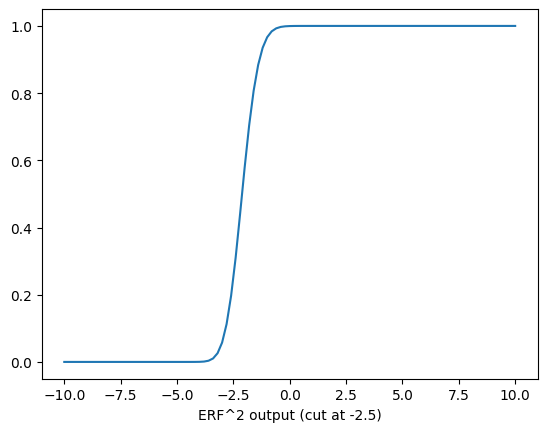

In [9]:
plt.plot(cut_range_values, run_eval)
plt.xlabel('Value')
plt.xlabel('ERF^2 output (cut at -2.5)')
plt.show()

Next, lets look at the loss function we are using - here we'll see there are plateaus along which a minimization algorithm isn't going to be able to decide how to optimize the cut (hence we must choose the cut varefully).

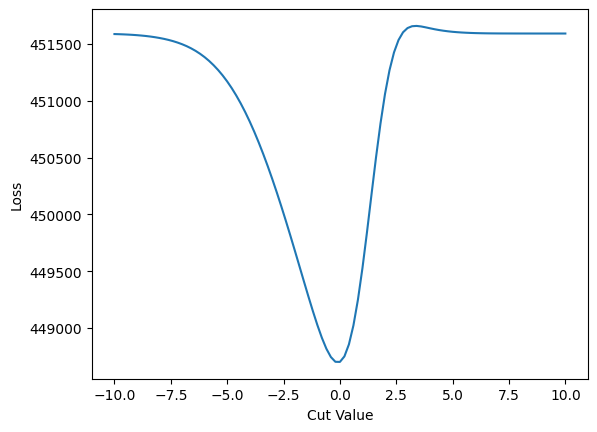

In [10]:
import optax

params = select_model.init(key, training_data)


def calc_value(params):
    preds = select_model.apply(params, key, training_data)
    preds = jax.nn.sigmoid(preds.squeeze())
    return optax.softmax_cross_entropy(preds, training_truth)


cut_range_values = jnp.linspace(-10.0, 10.0, 101)
cut_loss = [
    calc_value({"SelectionCut": {"cuts": jnp.asarray([v, v])}})
    for v in cut_range_values
]

plt.plot(cut_range_values, cut_loss)
plt.xlabel("Cut Value")
plt.ylabel("Loss")
plt.show()


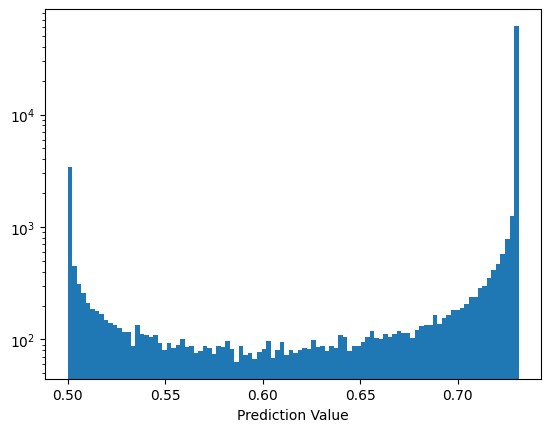

In [11]:
preds = select_model.apply({'SelectionCut': {'cuts': jnp.asarray([-3.4, -3.6])}}, key, training_data)
preds = preds.squeeze()
preds = jax.nn.sigmoid(preds)
plt.hist(preds, bins=100)
plt.yscale('log')
plt.xlabel('Prediction Value')
plt.show()

Any cut value greater than 2.5 (remember there are two cut values here) is likely to cause a problem. And any cut value less than -10.0 is going to cause a problem. Starting at 0 or -2.5, for example. should be fine.

Note that we've taken a short cut here and used our knowledge of the training data to determine that -2.5 is good for both cuts. If this were really a new problem we'd need to evaluate this with each cut individually. In reality any value where there is data should be fine - which suggests an easy way to start (say the median of each data for a straight up cut?).

Lets try a training and see how the training algorithm works with this.

In [12]:
select_params = train(
    model=select_model,
    key=key,
    epochs=1000,
    training_data=training_data,
    training_truth=training_truth,
)

NegLogLoss : 450008.03, epoch: 1
NegLogLoss : 449880.38, epoch: 100
NegLogLoss : 449746.75, epoch: 200
NegLogLoss : 449610.03, epoch: 300
NegLogLoss : 449472.38, epoch: 400
NegLogLoss : 449336.38, epoch: 500
NegLogLoss : 449205.22, epoch: 600
NegLogLoss : 449082.69, epoch: 700
NegLogLoss : 448972.72, epoch: 800
NegLogLoss : 448879.00, epoch: 900
NegLogLoss : 448803.69, epoch: 1000


In [13]:
print (select_params)

{'SelectionCut': {'cuts': DeviceArray([-0.6565423 , -0.51615274], dtype=float32)}}


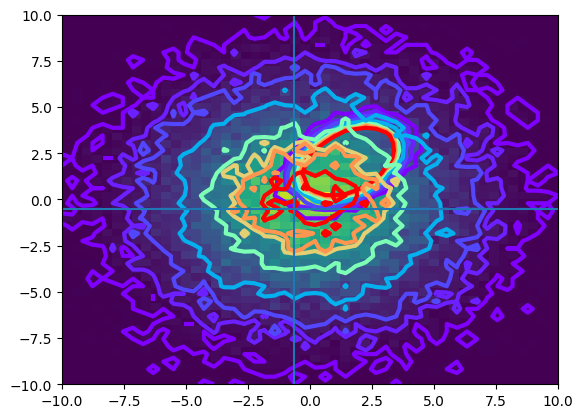

In [14]:
def plot_contour(data):
    counts,xbins,ybins,_ = plt.hist2d(data[:, 0], data[:, 1], bins=50, range=((-10, 10), (-10, 10)))
    plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=3, cmap = plt.cm.rainbow, levels = [1,5,10,25,50,70,80,100])

plot_contour(signal_data)
plot_contour(background_data)
cut_values = select_params['SelectionCut']['cuts']
plt.axhline(cut_values[1])
plt.axvline(cut_values[0])
plt.show()

In order to get the training to work efficiently, I had add the Adam optimizer to the training loop above. That also meant what was taking a lot more than 20K training now takes about 1000 (and it hadn't reached the optimal state by 20K either).

## MLP + Selection Cut Network

Build the forward network that combines all of this now.

In [15]:
def FeedForward(x):
    # The NN training
    mlp = hk.nets.MLP(output_sizes=[2,15,30,15,1])

    # The selection
    selection = Selection(initial_cuts=[0.0, 0.0])

    # Now the concat. Both these operate on the same input data (the tuple of
    # values) - which is required for this concat to work.
    combined = ModuleConcat([mlp, selection])

    # And then the multiply
    final = MultiplyRow()

    # And put them together in the proper way
    return final(combined(x))

model = hk.transform(FeedForward)

## Train

The training loop is the same as others we've used:

In [16]:
params = train(model=model,
    key = key, 
    epochs = 40000,
    training_data=training_data,
    training_truth=training_truth,
    learning_rate = 0.0002)

NegLogLoss : 449200.66, epoch: 1
NegLogLoss : 442189.28, epoch: 4000
NegLogLoss : 440938.69, epoch: 8000
NegLogLoss : 440314.22, epoch: 12000
NegLogLoss : 439975.09, epoch: 16000
NegLogLoss : 439773.81, epoch: 20000
NegLogLoss : 439667.97, epoch: 24000
NegLogLoss : 439608.62, epoch: 28000
NegLogLoss : 439573.06, epoch: 32000
NegLogLoss : 439553.41, epoch: 36000
NegLogLoss : 439545.34, epoch: 40000


When compared to the straight-up training found in the previous chapter, this is a lot slower:

* Slower on a per-epoch sense - almost but not quite a factor of two
* Slower to get the loss down. The comparison can be made directly here - because the loss calculation is identical in the two cases.

Over all on a comparison laptop, it was 9.5 minutes to do 10K epochs here, and 2 minutes to do 2000 there. At the end of 10K trainings here, the loss is about at 400 epochs there. Even at the end of 40K iterations and 40 minutes, it doesn't get as low a loss as the simple training.

In short, using the multiplyer method may not be the most efficient way to train here.

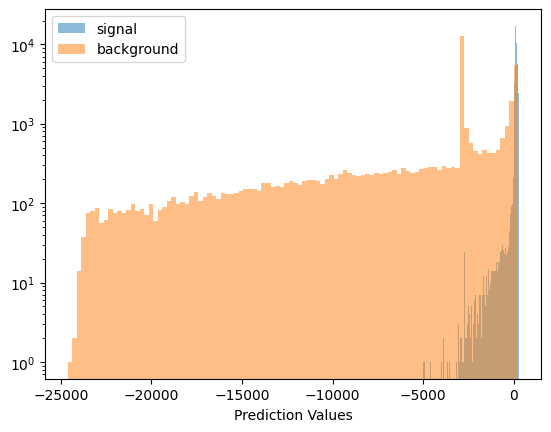

In [17]:
def plot_it(data, lbl):
    preds = model.apply(params, key, data)
    preds = preds.squeeze()
    # preds = jax.nn.sigmoid(preds)
    # preds = jnp.log(preds)
    plt.hist(preds, bins=100, label=lbl, alpha=0.5)


plot_it(signal_data, "signal")
plot_it(background_data, "background")
plt.yscale("log")
plt.xlabel("Prediction Values")
plt.legend()
plt.show()

I had to shift from negative log loss function to `optax`'s `softmax_cross_entropy` in order to make this work. The reason is that when you hit values of about -45 or so for predicted values, your negative log heads off towards negative infinity.

Which brings up an interesting fact - compared to the plain old NN training, note that we go down to $-1000$ in predictive values, where in the plain training it needs nothing beyond $-80$. 

## Examining the Training

First, lets take a look at the cut parameters to see where they ended up (remember, they were initialized to `1`).

In [18]:
trained_cut_values = params['SelectionCut']['cuts']
trained_cut_values

DeviceArray([-7.0540237, -7.1130943], dtype=float32)

Lets look at this graphically, showing a scatter plot of good and bad. First the prediction!

In [19]:
def infer(data, p, m = model):
    test_preds = m.apply(p, key, data)
    test_preds = jax.nn.sigmoid(test_preds.squeeze())
    test_preds = (test_preds > 0.5).astype(jnp.float32)
    return test_preds

infer_signal = infer(testing_signal, params)
infer_background = infer(testing_background, params)

Next, plot the classified and mis-classified signal and background

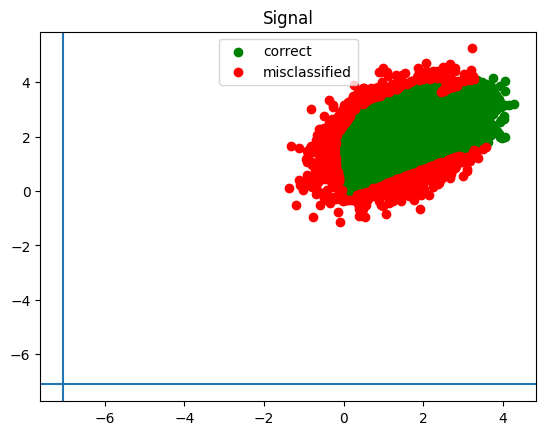

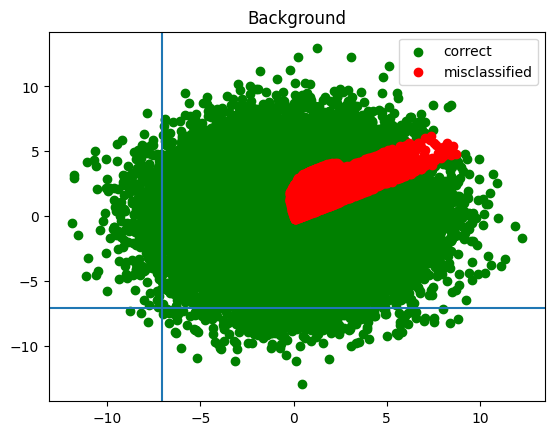

In [20]:
def plot_inference(data, results, value, title):
    good_data = data[results == value]
    plt.scatter(good_data[:, 0], good_data[:, 1], color='green', label='correct')
    bad_data = data[results != value]
    plt.scatter(bad_data[:, 0], bad_data[:, 1], color='red', label='misclassified')
    plt.title(title)
    plt.legend()

def plot_in_and_out(i_signal, i_background, cuts = None):
    plot_inference(testing_signal, i_signal, 1.0, 'Signal')
    if cuts is not None:
        plt.axhline(cuts[1])
        plt.axvline(cuts[0])
    plt.show()
    plot_inference(testing_background, i_background, 0.0, 'Background')
    if cuts is not None:
        plt.axhline(cuts[1])
        plt.axvline(cuts[0])
    plt.show()

plot_in_and_out(infer_signal, infer_background, trained_cut_values)

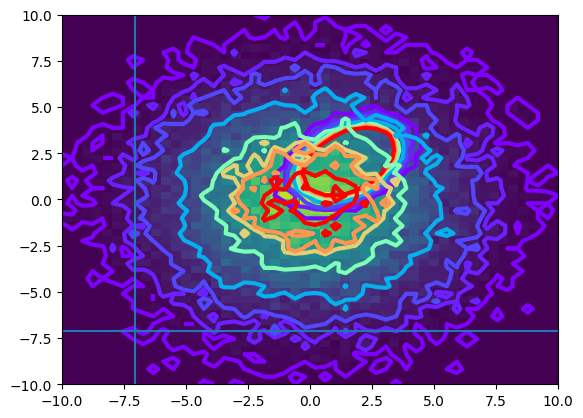

In [21]:
plot_contour(signal_data)
plot_contour(background_data)
cut_values = select_params['SelectionCut']['cuts']
plt.axhline(trained_cut_values[1])
plt.axvline(trained_cut_values[0])
plt.show()

Lets take apart the performance of the two components (the cut and the NN), and look at their performance individually, but with the training values that are used here.

In [22]:
model_mlp_only = hk.transform(lambda x: hk.nets.MLP(output_sizes=[2,15,30,15,1])(x))
model_selection_only = hk.transform(lambda x: MultiplyRow()(Selection(initial_cuts=[0.0, 0.0])(x)))

In [23]:
def do_sig_b_infer(m):
    return (
        infer(testing_signal, params, m=m),
        infer(testing_background, params, m=m)
    )
infer_s_mlp, infer_b_mlp = do_sig_b_infer(model_mlp_only)
infer_s_sel, infer_b_sel = do_sig_b_infer(model_selection_only)

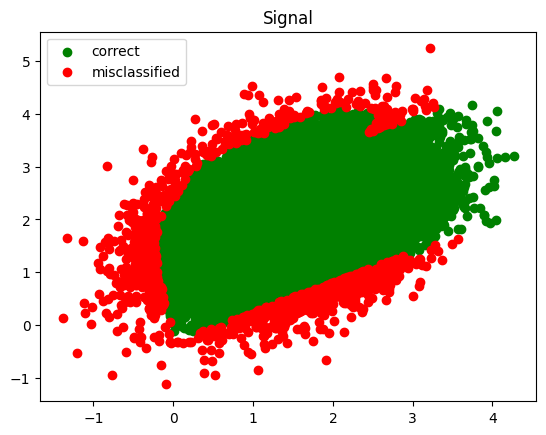

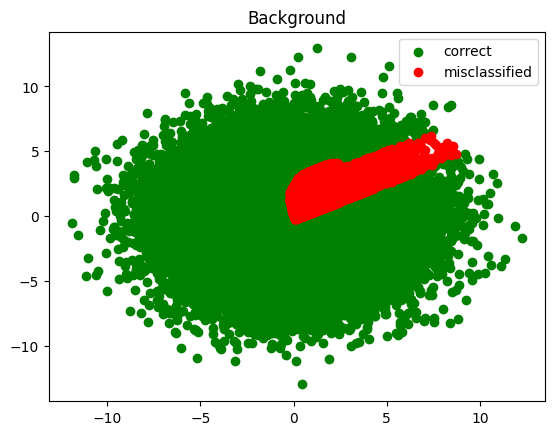

In [24]:
plot_in_and_out(infer_s_mlp, infer_b_mlp)

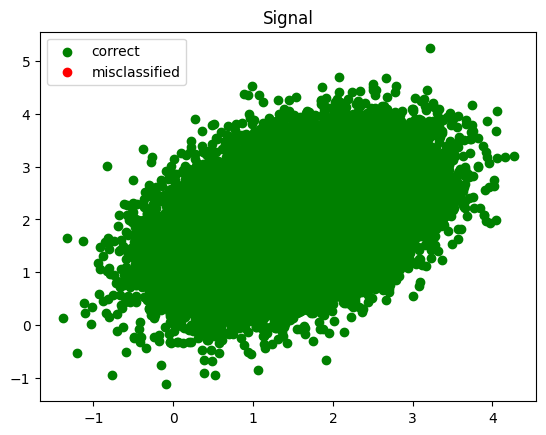

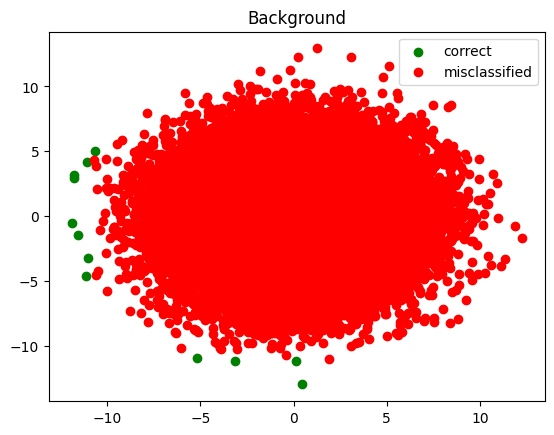

In [25]:
plot_in_and_out(infer_s_sel, infer_b_sel)

Fascinating in that it tried to push the cuts all the way out to the end - way past where there was any signal. I wonder what made it keep moving them?

The trend observed was generally this - each time I increased the number of training epochs the cuts were pushed further and further out.